# Import libraries

In [39]:
import os

import numpy as np
import pandas as pd

# Read data

In [40]:
DATASET_PATH = '../../data/processed/HAR'
DATASET_CSV_PATH = f'{DATASET_PATH}/UCF'

In [41]:
LABEL = {
    'Jump': 0,
    'Kick': 1,
    'Punch': 2,
    'Left': 3,
    'Right': 4,
    'Stand': 5
}

In [42]:
X = []
y = []

# Read all files in the dataset
for label in LABEL:
    for file in os.listdir(f'{DATASET_CSV_PATH}/Train/{label}'):
        df = pd.read_csv(f'{DATASET_CSV_PATH}/Train/{label}/{file}', sep=',')
        X.append(df)
        y.append(LABEL[label])
        print(f"Read file: {file}")

Read file: Jump_57.csv
Read file: Jump_20.csv
Read file: Jump_66.csv
Read file: Jump_15.csv
Read file: Jump_48.csv
Read file: Jump_24.csv
Read file: Jump_71.csv
Read file: Jump_23.csv
Read file: Jump_46.csv
Read file: Jump_52.csv
Read file: Jump_41.csv
Read file: Jump_36.csv
Read file: Jump_40.csv
Read file: Jump_19.csv
Read file: Jump_14.csv
Read file: resize_84.csv
Read file: Jump_5.csv
Read file: Jump_10.csv
Read file: resize_77.csv
Read file: Jump_67.csv
Read file: Jump_73.csv
Read file: Jump_72.csv
Read file: Jump_50.csv
Read file: resize_76.csv
Read file: Jump_33.csv
Read file: Jump_47.csv
Read file: resize_79.csv
Read file: Jump_26.csv
Read file: Jump_42.csv
Read file: Jump_28.csv
Read file: Jump_6.csv
Read file: Jump_31.csv
Read file: Jump_2.csv
Read file: Jump_11.csv
Read file: Jump_4.csv
Read file: Jump_25.csv
Read file: Jump_49.csv
Read file: Jump_69.csv
Read file: Jump_22.csv
Read file: Jump_32.csv
Read file: resize_86.csv
Read file: Jump_21.csv
Read file: Jump_68.csv
Read 

In [43]:
for i, element in enumerate(X):
    for column in element.columns:
        X[i][column] = X[i][column].apply(lambda x: np.array(x[1:-1].split(',')).astype(np.float32))

## Convert All Sequences to the Same Length

In [44]:
# Get the maximum length of all sequences
all_dim = []
for i, element in enumerate(X):
    all_dim.append(element.shape[0])
    print(f"Element {i} shape: {np.shape(element)}, label: {y[i]}")

Element 0 shape: (60, 33), label: 0
Element 1 shape: (13, 33), label: 0
Element 2 shape: (31, 33), label: 0
Element 3 shape: (67, 33), label: 0
Element 4 shape: (61, 33), label: 0
Element 5 shape: (19, 33), label: 0
Element 6 shape: (67, 33), label: 0
Element 7 shape: (31, 33), label: 0
Element 8 shape: (64, 33), label: 0
Element 9 shape: (72, 33), label: 0
Element 10 shape: (34, 33), label: 0
Element 11 shape: (20, 33), label: 0
Element 12 shape: (36, 33), label: 0
Element 13 shape: (61, 33), label: 0
Element 14 shape: (54, 33), label: 0
Element 15 shape: (21, 33), label: 0
Element 16 shape: (31, 33), label: 0
Element 17 shape: (31, 33), label: 0
Element 18 shape: (19, 33), label: 0
Element 19 shape: (31, 33), label: 0
Element 20 shape: (55, 33), label: 0
Element 21 shape: (70, 33), label: 0
Element 22 shape: (61, 33), label: 0
Element 23 shape: (19, 33), label: 0
Element 24 shape: (17, 33), label: 0
Element 25 shape: (62, 33), label: 0
Element 26 shape: (24, 33), label: 0
Element 27 

### Handle the Outliers and make the lengths of all sequences the same
Handle different lengths of sequences
    Set the maximum length = 1.5 * IQR + Q3
    
    * Case 1: If e_dim < Max_dim, then increase the length of the sequence by duplicating each row until the length of the sequence is equal to Max_dim
    * Case 2: If e_dim > Max_dim, then truncate randomly the sequence until the length of the sequence is equal to Max_dim
    * Case 3: If e_dim = Max_dim, then keep the sequence as it is

In [45]:
Max_dim = 35

In [46]:
X_train_temp = []
Y_train_temp = []


def pad_length(ele, max_dim, metric_temp: list = None) -> np.array:
    if metric_temp is None:
        metric_temp = []
    if ele.shape[0] == max_dim:
        return pd.DataFrame(ele)

    step = max(1, ele.shape[0] // (max_dim - ele.shape[0]))

    for j in range(0, ele.shape[0]):
        metric_temp.append(ele.iloc[j])
        if len(metric_temp) == max_dim:
            break
        if j % step == 0:
            metric_temp.append(ele.iloc[j])
        if len(metric_temp) == max_dim:
            break
    return pad_length(pd.DataFrame(metric_temp), max_dim)


def truncate_length(ele, max_dim, start=0) -> np.array:
    if ele.shape[0] == max_dim:
        return pd.DataFrame(ele)

    metrics_temp: list = []
    step = max(2, ele.shape[0] // (ele.shape[0] - max_dim))
    j = start
    while len(metrics_temp) != max_dim:
        metrics_temp.append(ele.iloc[j])
        j = (j + step) % ele.shape[0]
    return pd.DataFrame(metrics_temp)


def pad_and_truncate(ele, max_dim: int = 35) -> np.array:
    list_elements: list = []
    current_length = ele.shape[0]

    if current_length == max_dim:
        return [ele]

    dev = max(int(round(current_length / max_dim)), 1)
    if dev * max_dim > current_length:
        new_element = pad_length(ele, max_dim * dev)

        if new_element.shape[0] > max_dim:
            for step in range(dev):
                list_elements.append(truncate_length(new_element, max_dim, step))
        else:
            list_elements.append(new_element)
    else:
        for step in range(dev):
            list_elements.append(truncate_length(ele, max_dim, step))
    return list_elements


# Pad all sequences to the same length
for i, element in enumerate(X):
    print(f"Before padding, element {i} shape: {np.shape(element)}")
    padded_element = pad_and_truncate(element, Max_dim)
    print(f"After padding, element {i} shape: {np.shape(padded_element)}")
    X_train_temp = X_train_temp + padded_element
    Y_train_temp = Y_train_temp + [y[i]] * len(padded_element)
    print(f"After padding X_train_temp, element {i} shape: {np.shape(X_train_temp)}")
    print(f"After padding Y_train_temp, element {i} shape: {np.shape(Y_train_temp)}")
    print('-----------------------------------')
# test = X[15]
# padded_element = pad_and_truncate(test, Max_dim)
# np.array(padded_element).shape

Before padding, element 0 shape: (60, 33)
After padding, element 0 shape: (2, 35, 33)
After padding X_train_temp, element 0 shape: (2, 35, 33)
After padding Y_train_temp, element 0 shape: (2,)
-----------------------------------
Before padding, element 1 shape: (13, 33)
After padding, element 1 shape: (1, 35, 33)
After padding X_train_temp, element 1 shape: (3, 35, 33)
After padding Y_train_temp, element 1 shape: (3,)
-----------------------------------
Before padding, element 2 shape: (31, 33)
After padding, element 2 shape: (1, 35, 33)
After padding X_train_temp, element 2 shape: (4, 35, 33)
After padding Y_train_temp, element 2 shape: (4,)
-----------------------------------
Before padding, element 3 shape: (67, 33)
After padding, element 3 shape: (2, 35, 33)
After padding X_train_temp, element 3 shape: (6, 35, 33)
After padding Y_train_temp, element 3 shape: (6,)
-----------------------------------
Before padding, element 4 shape: (61, 33)
After padding, element 4 shape: (2, 35, 33

In [47]:
X_train_ = np.array(X_train_temp)

In [48]:
X_test = np.full((X_train_.shape[0], X_train_.shape[1], X_train_.shape[2], 3), np.nan, dtype=np.float32)

for i, element in enumerate(X_train_):
    for j, row in enumerate(element):
        for k, value in enumerate(row):
            # Check if the value is np.array([nan, nan, nan])
            if np.isnan(value).all():
                X_train_[i][j][k] = np.array([np.nan, np.nan, np.nan], dtype=np.float32)
            else:
                X_train_[i][j][k] = value

            X_test[i][j][k] = X_train_[i][j][k][:3]

## Handle Fill NaN Values

### Step 1: Compute the variance of each metric for each sequence.

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


### Step 1: Compute the variance of each metric for each sequence.

In [49]:
variance_metric = np.empty((X_test.shape[0], X_test.shape[2], 3), dtype=np.float32)
variance_metric.shape

(718, 33, 3)

In [50]:
cls_nan = dict()

for i, element in enumerate(X_test):
    sub_variance_metric = np.empty((element.shape[1], 3), dtype=np.float32)

    for j in range(element.shape[1]):
        variance = np.array([np.nan, np.nan, np.nan], dtype=np.float32)

        # If there are more than 1 non-NaN values, calculate variance
        if np.count_nonzero(~np.isnan(element[:, j])) > 1:
            variance = np.nanvar(element[:, j], axis=0)
            print(variance)
        else:
            if i not in cls_nan:
                cls_nan[i] = []
            cls_nan[i].append(j)
        # convert to list
        sub_variance_metric[j] = variance
    # print(sub_variance_metric)
    variance_metric[i] = sub_variance_metric

[1.5271826e-05 2.0467925e-03 6.2849610e-03]
[1.7878367e-05 2.1600334e-03 6.4886492e-03]
[2.0784768e-05 2.1587517e-03 6.4835278e-03]
[2.3506920e-05 2.1582665e-03 6.4806612e-03]
[1.5447087e-05 2.1547081e-03 6.3725025e-03]
[1.7197355e-05 2.1594816e-03 6.3760462e-03]
[1.7824799e-05 2.1611487e-03 6.3766879e-03]
[3.3325799e-05 2.2089765e-03 6.4768866e-03]
[3.0099796e-05 2.2453426e-03 5.8840257e-03]
[2.3648086e-05 2.0144458e-03 6.2092911e-03]
[2.0116475e-05 2.0149872e-03 6.0374402e-03]
[7.7037927e-05 2.0767064e-03 5.2269469e-03]
[7.8914214e-05 2.3131294e-03 5.0604860e-03]
[6.6422355e-05 2.2431808e-03 5.2870340e-03]
[7.3960487e-05 2.4953482e-03 3.9446643e-03]
[5.0016712e-05 2.3213918e-03 4.7030118e-03]
[0.00012208 0.00276223 0.00548522]
[6.9160997e-05 2.3537402e-03 4.7404557e-03]
[0.00020634 0.002805   0.00605205]
[5.6541470e-05 2.3775662e-03 4.3723388e-03]
[0.00024836 0.00279011 0.00586937]
[4.638471e-05 2.378113e-03 4.432054e-03]
[0.00021452 0.00276889 0.00555016]
[2.7824737e-05 1.9054544e-0

In [51]:
variance_metric = np.array([variance_metric], dtype=np.float32)

In [52]:
variance_metric = variance_metric.reshape(variance_metric.shape[1], variance_metric.shape[2], variance_metric.shape[3])

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


In [53]:
# Function to fill NaN values based on the described cases
def fill_nan(element, variance_metric):
    old_value = None
    k = 0

    for i in range(element.shape[0]):
        if np.isnan(element[i]).all():
            # Case 1: If element[i] doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
            if old_value is None:
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        element[i] = element[l] + abs(i - l) * variance_metric
                        break
            else:
                # Case 2: If element[i] doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
                flat = False
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        if l != k:
                            element[i] = old_value + (element[l] - old_value) / ((i - k) / (l - k))
                            flat = True
                            break
                if not flat:
                    # Case 3: If element[i] has values both before and after, then use the nearest previous and posterior elements
                    element[i] = old_value - abs(i - k) * variance_metric
        old_value = element[i]
    return element

In [54]:
X_test_new = np.empty(X_test.shape, dtype=np.float32)
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[2]):
        # print("Shape of element: ", X_train[i][: , j].shape)
        # print("Shape of variance: ", variance_metric[i][j].shape)
        X_test_new[i][:, j] = fill_nan(X_test[i][:, j], variance_metric[i][j])

In [55]:
np.isnan(np.array([np.nan, np.nan, 0])).sum()

2

In [56]:
variance_metric[0][2]

array([2.0784768e-05, 2.1587517e-03, 6.4835278e-03], dtype=float32)

In [57]:
# Drop data with NaN values
drop_index = list(cls_nan.keys())
# Drop data in X_train_new that has index in drop_index
X_train_new = np.delete(X_test_new, drop_index, axis=0)
y_train = np.delete(X_test_new, drop_index, axis=0)

## LSTM model LSTM model

In [58]:
from tensorflow import keras

In [59]:
# Reshape the data
X_test_reshaped = X_test_new.reshape(X_test_new.shape[0], X_test_new.shape[1],
                                     X_test_new.shape[2] * X_test_new.shape[3])

In [64]:
# load the model
model = keras.models.load_model('../../results/models/models.h5')

2024-10-20 00:55:41.735100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-20 00:55:41.736137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-20 00:55:41.736565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2024-10-20 00:55:45.707112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-20 00:55:45.707902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-20 00:55:45.708392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

23/23 [==============================] - 1s 26ms/step


Text(0.5, 80.7222222222222, 'Predicted')

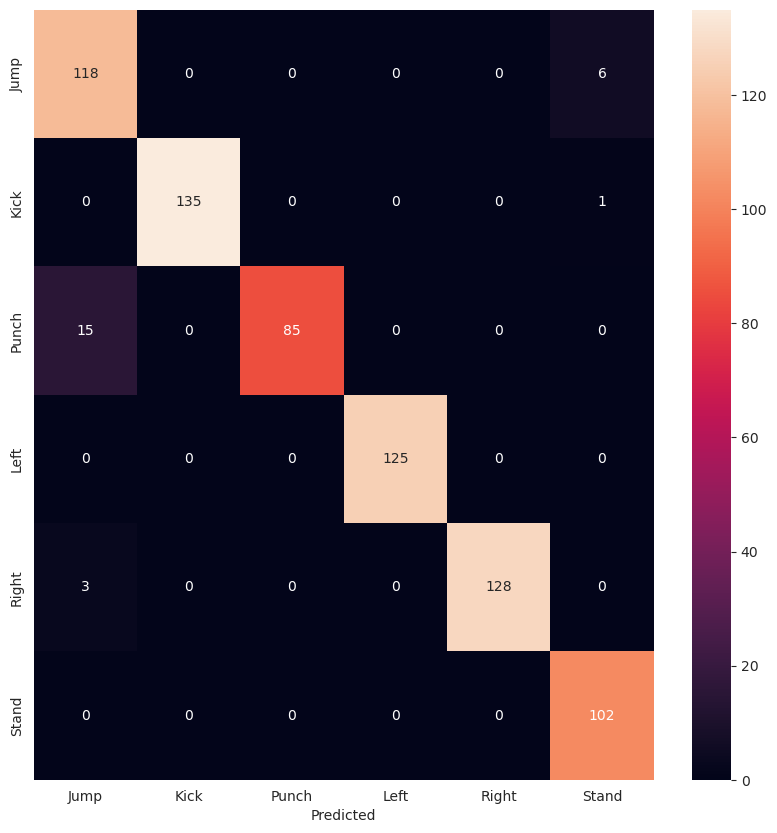

In [65]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(Y_train_temp)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=LABEL.keys(), yticklabels=LABEL.keys())
plt.xlabel('Predicted')

In [62]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}

In [63]:
# Show the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=LABEL.keys()))

              precision    recall  f1-score   support

        Jump       0.84      0.98      0.90       124
        Kick       1.00      0.99      0.99       136
       Punch       0.92      0.85      0.89       100
        Left       1.00      0.98      0.99       125
       Right       0.96      0.98      0.97       131
       Stand       0.99      0.89      0.94       102

    accuracy                           0.95       718
   macro avg       0.95      0.94      0.95       718
weighted avg       0.95      0.95      0.95       718

